In [43]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

In [9]:
import torch
torch.__version__

'1.12.1'

In [10]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [11]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())



In [12]:
census_income = pd.read_csv(out)

In [13]:
census_income.shape

(32560, 15)

In [14]:
census_income.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [15]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index



In [16]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


In [17]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]



In [19]:
from pytorch_tabnet.tab_model import TabNetRegressor

In [20]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

C:\Users\ashik.emon\AppData\Local\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [21]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)



In [22]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [23]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [24]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 0.16527 | train_rmsle: 0.09161 | train_mae: 0.37027 | train_rmse: 0.71539 | train_mse: 0.51179 | valid_rmsle: 0.09359 | valid_mae: 0.37648 | valid_rmse: 0.78013 | valid_mse: 0.60861 |  0:00:04s
epoch 1  | loss: 0.1305  | train_rmsle: 0.11043 | train_mae: 0.38239 | train_rmse: 0.4569  | train_mse: 0.20876 | valid_rmsle: 0.10932 | valid_mae: 0.38163 | valid_rmse: 0.4544  | valid_mse: 0.20648 |  0:00:10s
epoch 2  | loss: 0.12423 | train_rmsle: 0.08162 | train_mae: 0.31836 | train_rmse: 0.39908 | train_mse: 0.15927 | valid_rmsle: 0.07949 | valid_mae: 0.31386 | valid_rmse: 0.39742 | valid_mse: 0.15794 |  0:00:15s
epoch 3  | loss: 0.1217  | train_rmsle: 0.07834 | train_mae: 0.31244 | train_rmse: 0.37862 | train_mse: 0.14335 | valid_rmsle: 0.07629 | valid_mae: 0.30741 | valid_rmse: 0.37359 | valid_mse: 0.13957 |  0:00:20s
epoch 4  | loss: 0.11921 | train_rmsle: 0.06601 | train_mae: 0.27641 | train_rmse: 0.35516 | train_mse: 0.12614 | valid_rmsle: 0.06612 | valid_mae: 0.2777  

epoch 39 | loss: 0.09777 | train_rmsle: 0.04768 | train_mae: 0.20722 | train_rmse: 0.3159  | train_mse: 0.09979 | valid_rmsle: 0.0477  | valid_mae: 0.20655 | valid_rmse: 0.31543 | valid_mse: 0.0995  |  0:03:15s
epoch 40 | loss: 0.09932 | train_rmsle: 0.04964 | train_mae: 0.2094  | train_rmse: 0.31496 | train_mse: 0.0992  | valid_rmsle: 0.0492  | valid_mae: 0.20748 | valid_rmse: 0.31269 | valid_mse: 0.09778 |  0:03:19s
epoch 41 | loss: 0.09937 | train_rmsle: 0.04813 | train_mae: 0.212   | train_rmse: 0.31801 | train_mse: 0.10113 | valid_rmsle: 0.04764 | valid_mae: 0.21009 | valid_rmse: 0.31544 | valid_mse: 0.0995  |  0:03:24s
epoch 42 | loss: 0.09837 | train_rmsle: 0.04765 | train_mae: 0.2079  | train_rmse: 0.3176  | train_mse: 0.10087 | valid_rmsle: 0.04732 | valid_mae: 0.20713 | valid_rmse: 0.31614 | valid_mse: 0.09994 |  0:03:29s
epoch 43 | loss: 0.09765 | train_rmsle: 0.04989 | train_mae: 0.21008 | train_rmse: 0.31502 | train_mse: 0.09923 | valid_rmsle: 0.05006 | valid_mae: 0.20981 

epoch 78 | loss: 0.09524 | train_rmsle: 0.04569 | train_mae: 0.20046 | train_rmse: 0.31215 | train_mse: 0.09744 | valid_rmsle: 0.04602 | valid_mae: 0.20018 | valid_rmse: 0.31225 | valid_mse: 0.0975  |  0:06:24s
epoch 79 | loss: 0.09559 | train_rmsle: 0.048   | train_mae: 0.20421 | train_rmse: 0.30869 | train_mse: 0.09529 | valid_rmsle: 0.04889 | valid_mae: 0.2049  | valid_rmse: 0.31106 | valid_mse: 0.09676 |  0:06:28s
epoch 80 | loss: 0.09458 | train_rmsle: 0.0477  | train_mae: 0.19866 | train_rmse: 0.30882 | train_mse: 0.09537 | valid_rmsle: 0.04836 | valid_mae: 0.19823 | valid_rmse: 0.31057 | valid_mse: 0.09646 |  0:06:33s
epoch 81 | loss: 0.095   | train_rmsle: 0.04733 | train_mae: 0.20612 | train_rmse: 0.31091 | train_mse: 0.09666 | valid_rmsle: 0.04762 | valid_mae: 0.20524 | valid_rmse: 0.31117 | valid_mse: 0.09683 |  0:06:38s
epoch 82 | loss: 0.09442 | train_rmsle: 0.04611 | train_mae: 0.19845 | train_rmse: 0.30914 | train_mse: 0.09557 | valid_rmsle: 0.04685 | valid_mae: 0.19911 

C:\Users\ashik.emon\AppData\Local\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [28]:
from sklearn.metrics import mean_squared_error


In [29]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")



BEST VALID SCORE FOR census-income : 0.0952518536646394
FINAL TEST SCORE FOR census-income : 0.0984285323548618


In [30]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)



Successfully saved model at ./tabnet_model_test_1.zip


In [31]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

C:\Users\ashik.emon\AppData\Local\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [32]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR census-income : 0.0984285323548618


In [35]:
assert(test_score == loaded_test_mse)

In [36]:
clf.feature_importances_

array([1.01372286e-01, 1.42847258e-02, 1.65239765e-05, 4.80693064e-02,
       3.93596423e-02, 6.63457265e-02, 3.46283070e-01, 6.21438897e-04,
       1.55885192e-02, 1.22489142e-02, 2.68846062e-01, 1.56294216e-05,
       6.44129950e-02, 2.25351605e-02])

In [37]:
explain_matrix, masks = clf.explain(X_test)

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline

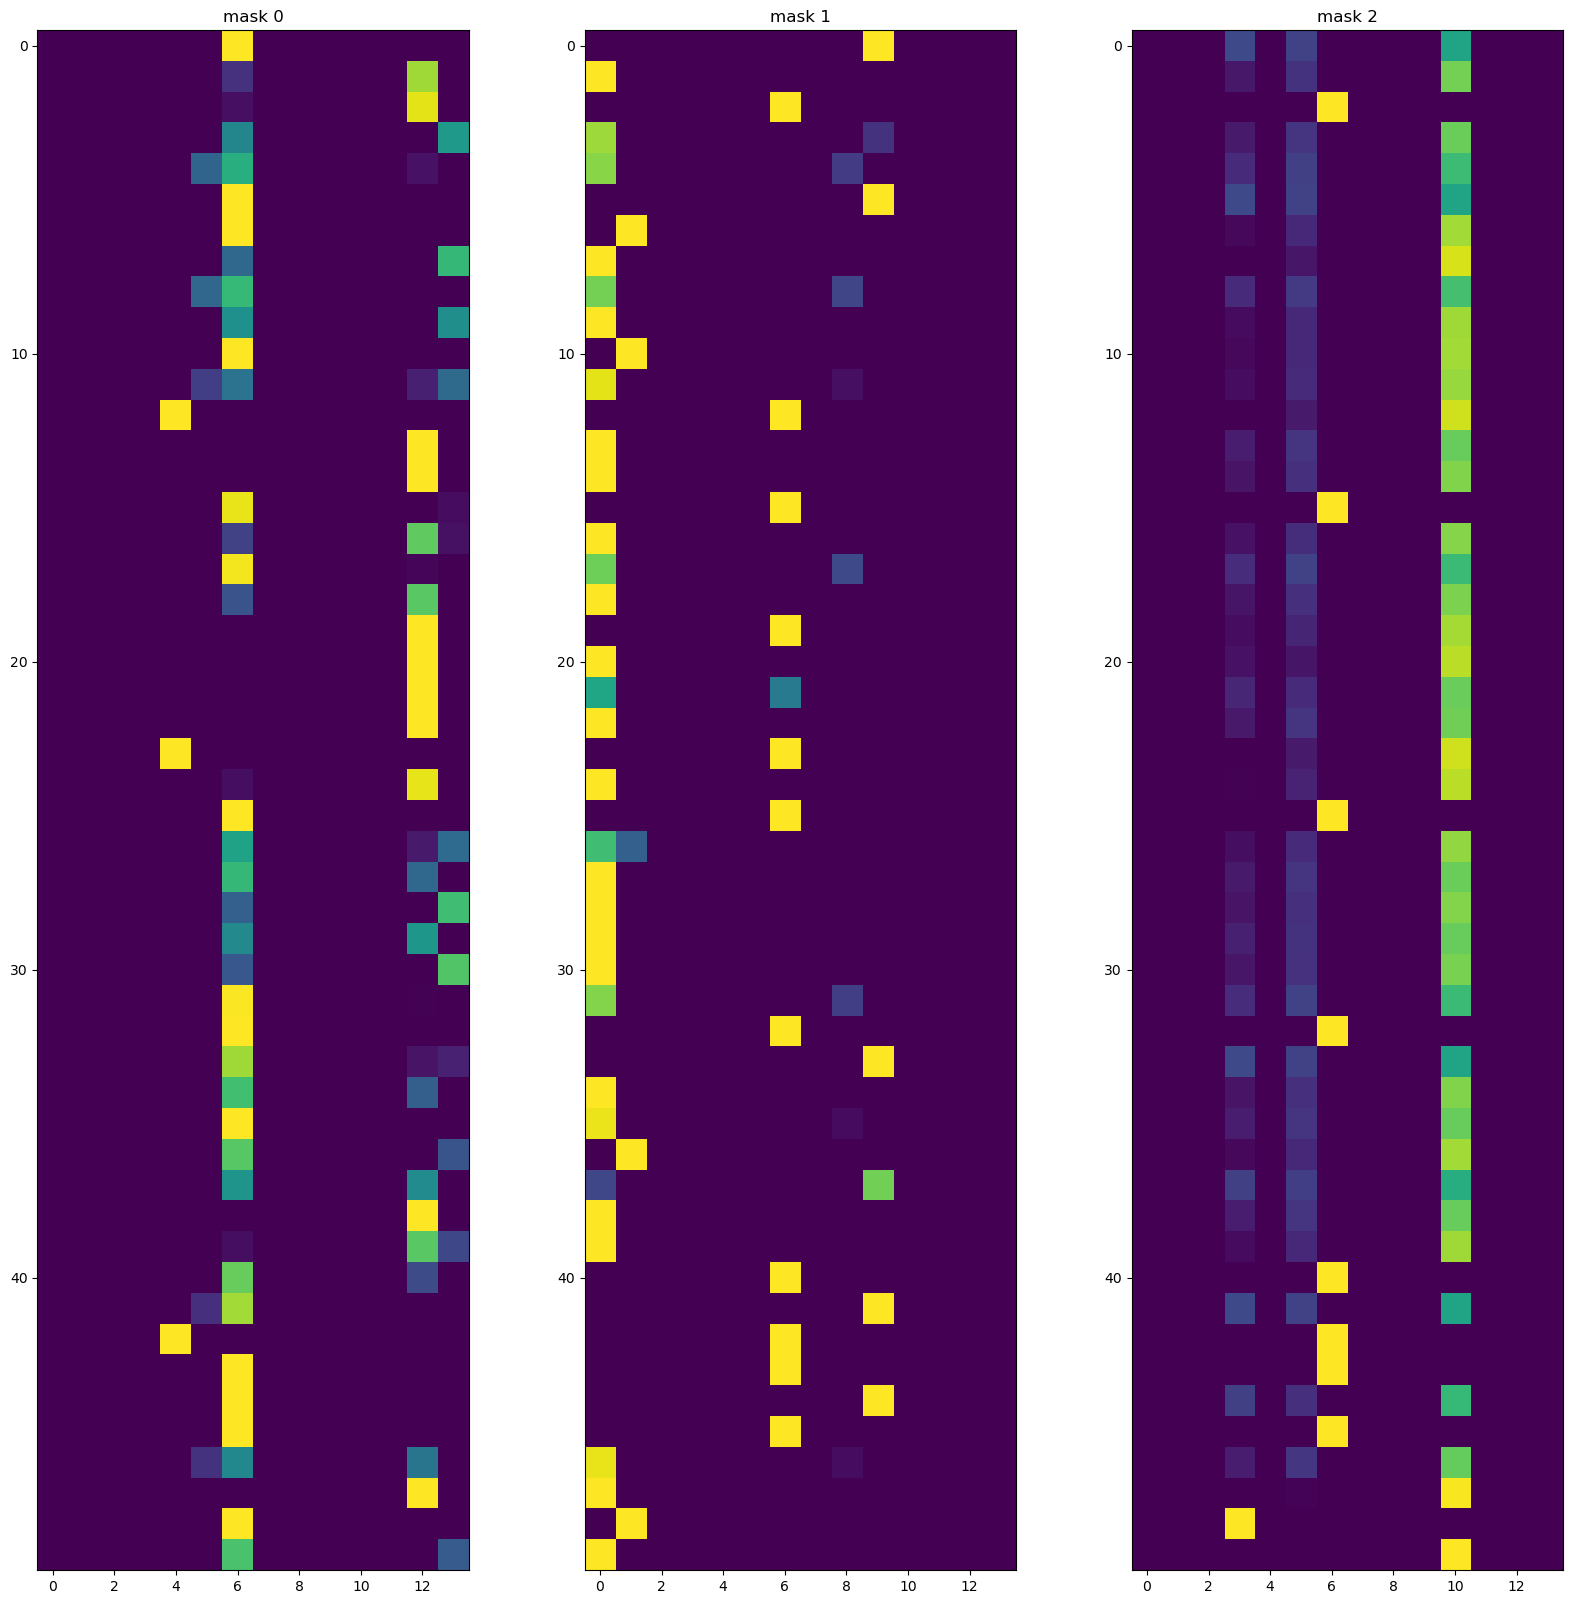

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [46]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.46992


C:\Users\ashik.emon\AppData\Local\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.33056
[20]	validation_0-rmse:0.30274
[30]	validation_0-rmse:0.29676
[40]	validation_0-rmse:0.29514
[50]	validation_0-rmse:0.29520
[60]	validation_0-rmse:0.29497
[70]	validation_0-rmse:0.29518
[80]	validation_0-rmse:0.29521
[90]	validation_0-rmse:0.29574
[100]	validation_0-rmse:0.29599
[101]	validation_0-rmse:0.29598


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

In [47]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

0.08693414488964239
0.09148941118733249
